In [5]:
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
from matplotlib.lines import Line2D
PLT_CELL = 5
FIG_DIR = "./"
DATA_PATH = "../../data/simulated/Synthetic_1000/dyn-BFStrange/dyn-BFStrange-1000-1/"

In [6]:
adata = ad.read_h5ad(DATA_PATH + "anndata.h5ad")

In [25]:
sc.tl.tsne(adata, perplexity = 250, random_state = 1)

Text(0, 0.5, 'tsne2')

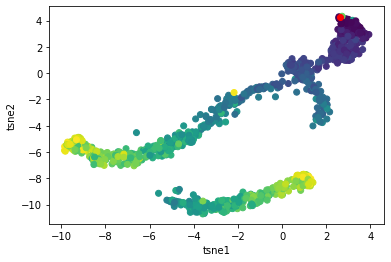

In [26]:
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = adata.obs.dpt)
plt.scatter(adata.obsm["X_tsne"][adata.uns['iroot'], 0], adata.obsm["X_tsne"][adata.uns['iroot'], 1], c = "red")
plt.xlabel("tsne1")
plt.ylabel("tsne2")

In [27]:
sc.tl.dpt(adata, n_branchings = 1)

Text(0.5, 0, 'tSNE2')

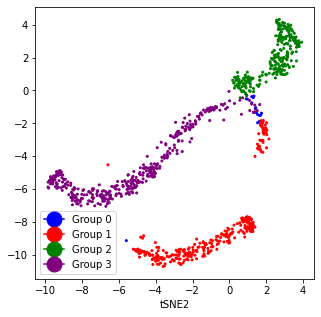

In [28]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {"0" : "blue", "1" : "red", "2" : "green", "3" : "purple"}
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = [color_dict[x] for x in adata.obs.dpt_groups], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color=v, label='Group %s' % k, markerfacecolor=v, markersize=15)
                    for (k, v) in color_dict.items()]
plt.gca().legend(handles=legend_elements, loc='lower left')
plt.xlabel("tSNE1")
plt.xlabel("tSNE2")

In [29]:
# remap dpt groups for Synthetic_1000
# 1
dpt_group_map = {"0" : "0", 
                 "1" : "1", 
                 "2" : "0", 
                 "3" : "2"}
adata.obs.dpt_groups = adata.obs.dpt_groups.apply(lambda x : dpt_group_map[x])

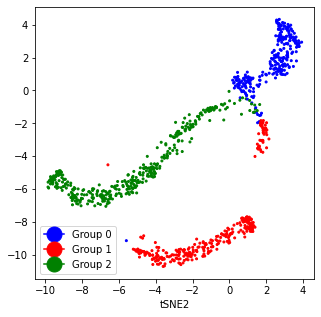

In [30]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {"0" : "blue", "1" : "red", "2" : "green", "3" : "purple"}
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = [color_dict[x] for x in adata.obs.dpt_groups], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color=v, label='Group %s' % k, markerfacecolor=v, markersize=15)
                    for (k, v) in color_dict.items()]
plt.gca().legend(handles=legend_elements[0:3], loc='lower left')
plt.xlabel("tSNE1")
plt.xlabel("tSNE2")
plt.savefig(FIG_DIR + "bifurc_sim_tsne.pdf")

In [33]:
np.save(DATA_PATH + "X_tsne2.npy", adata.obsm["X_tsne"])
np.save(DATA_PATH + "dpt_pseudotime.npy", adata.obs.dpt_pseudotime)
np.save(DATA_PATH + "clusterid.npy", np.array([int(x) for x in adata.obs.dpt_groups]))